<div style="display: flex; background-color: RGB(255,114,0);" >
<div>
<img src="img/fraudeur_-_BNPP_PF_-_finale.jpg" width="300"/>
</div>

# PROJET - Comment démasquer les fraudeurs ? <mark>ACP</mark>
</div>

par BNP Paribas PF

Lien vers le challenge : https://challengedata.ens.fr/participants/challenges/104/

<div style="display: flex; background-color: Blue; padding: 15px;" >

## 1.CHARGEMENT des données
</div>


In [1]:
from os import getcwd
from os.path import join
import pandas as pd
import missingno as msno

import warnings
warnings.filterwarnings("ignore")

from bnp_paribas_acp_util import *

# ---------------------------------------------------------------------------------------------
#                               MAIN
# ---------------------------------------------------------------------------------------------
verbose = 1

target = "fraud_flag"

# Récupère le répertoire du programme
execution_path = getcwd().split("projet_bnp_paribas_fraudeurs")[0]
execution_path = join(execution_path, 'projet_bnp_paribas_fraudeurs')

model_path = join(execution_path, 'model')

data_set_path = join(execution_path, 'dataset')
train_file_name = "train_complete_encoded_hyper_light_2023_01_19.csv"
data_set_train_file_name = join(data_set_path, train_file_name)

print(f"Current execution path : {execution_path}")
print(f"Dataset path : {data_set_path}")

Current execution path : c:\Users\User\WORK\workspace-ia\PROJETS\projet_bnp_paribas_fraudeurs
Dataset path : c:\Users\User\WORK\workspace-ia\PROJETS\projet_bnp_paribas_fraudeurs\dataset


> Chargement des données pré-traitées

In [2]:
# [load_splited_data   ]	INFO  Chargement des données train sources...                          
# [load_splited_data   ]	INFO  (92790, 1981) train données chargées                          
# [load_splited_data   ]	INFO  Séparation de X et y...                          
# [load_splited_data   ]	INFO  split du dataset_path...                          
# [load_splited_data   ]	INFO  5 dataset LOAD                          
# [load_splited_data   ]	INFO  (74232, 1980) / (18558, 1980) 
over_name="BorderlineSMOTE"
random_state = 42
dataset_dict = load_splited_data(dataset_path=data_set_train_file_name,over_name=over_name, random_state = random_state, save_it=True, force=False, verbose=verbose)

X_train, X_test, y_train, y_test, train_origin = dataset_dict.get("X_train", None), dataset_dict.get("X_test", None), dataset_dict.get("y_train", None), dataset_dict.get("y_test", None), dataset_dict.get("train_origin", None)

[load_splited_data   ]	INFO  IN PROGRESS...                          
[load_splited_data   ]	INFO  over BorderlineSMOTE Loading X_train...                          
[load_over_dataset   ]	INFO  (146370, 1982) datas LOAD                          
[load_splited_data   ]	INFO  set X_test Loading X_test...                          
[reduce_data_by_typing]	INFO  ID                           int64
Nb_of_items                float64
item_BED LINEN_nb          float64
item_BED LINEN_cash        float64
item_BATHROOM_nb           float64
                            ...   
make_TEMPLE ISLAND_nb      float64
make_TEMPLE ISLAND_cash    float64
make_GHD_nb                float64
make_GHD_cash              float64
amount                     float64
Length: 1981, dtype: object                          
[reduce_data_by_typing]	INFO  ID                           int64
Nb_of_items                   int8
item_BED LINEN_nb             int8
item_BED LINEN_cash        float16
item_BATHROOM_nb              i

<div style="display: flex; background-color: Blue; padding: 15px;" >

## 3.ACP
</div>

Commenter à chaque étape avec les observations

1. centrer et réduire les données
1. calculer les composantes principales
1. afficher et interpréter les axes de corrélations sans NAA
1. afficher le nuage de point des composantes principales (au moins les 2 premières) et le cercle des corrélations (cercles avec les flêches des variables)
  * Afficher l'inertie associée à chacun des 2 axes. pour identifier le taux de données représenté
1. faire le graphe des éboulis des valeurs propres
  * on a tendance à ne pas considérer comme importants les axes dont l’inertie associée est inférieure à (100/p)% , car ils représentent moins de variabilité qu’une seule variable initiale. La valeur de (100/p)% est celle obtenue quand toutes les variables sont indépendantes deux à deux. Ce critère est appelé critère de Kaiser.

<div style="display: flex; background-color: Green; padding: 7px;" >

### 3.1. Sélection des colonnes à prendre en compte
</div>

In [3]:
numeric_columns_name = list(X_train.columns)
numeric_columns_name.remove('ID')
numeric_columns_name

['Nb_of_items',
 'item_BED LINEN_nb',
 'item_BED LINEN_cash',
 'item_BATHROOM_nb',
 'item_BATHROOM_cash',
 'item_DISPOSABLE TABLEWARE CUTLERY_nb',
 'item_DISPOSABLE TABLEWARE CUTLERY_cash',
 'item_TOYS_nb',
 'item_TOYS_cash',
 'item_AUDIO ACCESSORIES_nb',
 'item_AUDIO ACCESSORIES_cash',
 'item_PICNICWARE_nb',
 'item_PICNICWARE_cash',
 'item_BAGS CARRY CASES_nb',
 'item_BAGS CARRY CASES_cash',
 'item_NURSERY LINEN_nb',
 'item_NURSERY LINEN_cash',
 'item_NURSERY ACCESSORIES_nb',
 'item_NURSERY ACCESSORIES_cash',
 'item_COMPUTER SOFTWARE_nb',
 'item_COMPUTER SOFTWARE_cash',
 'item_AERIALS REMOTE CONTROLS_nb',
 'item_AERIALS REMOTE CONTROLS_cash',
 'item_EASTER DECORATIONS_nb',
 'item_EASTER DECORATIONS_cash',
 'item_OUTDOOR FURNITURE_nb',
 'item_OUTDOOR FURNITURE_cash',
 'item_KITCHEN ACCESSORIES_nb',
 'item_KITCHEN ACCESSORIES_cash',
 'item_CHILDRENS ACCESSORIES_nb',
 'item_CHILDRENS ACCESSORIES_cash',
 'item_GREETING CARDS PERSONALISED STATIONERY_nb',
 'item_GREETING CARDS PERSONALISED 

In [4]:
# selection des colonnes à prendre en compte dans l'ACP
df_centre_reduit = X_train[numeric_columns_name]
print("{:_} NAN".format(df_centre_reduit.isna().sum().sum()))

0 NAN


<div style="display: flex; background-color: Green; padding: 7px;" >

### 3.2. Choix du nombre de composantes
</div>

In [5]:
from sklearn import decomposition
from sklearn import preprocessing

In [6]:
# choix du nombre de composantes à calculer
ACP_NB_COMPOSANTES = len(numeric_columns_name)

# préparation des données pour l'ACP
X = df_centre_reduit.values
names = df_centre_reduit.index # ou data.index pour avoir les intitulés
features = df_centre_reduit.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [8]:
# calculer les composantes principales
pca = decomposition.PCA(n_components=ACP_NB_COMPOSANTES)
x_projeected = pca.fit_transform(X_scaled)
pd.DataFrame(x_projeected, index=df_centre_reduit.index, columns=["F"+str(i+1) for i in range(ACP_NB_COMPOSANTES)])

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F1971,F1972,F1973,F1974,F1975,F1976,F1977,F1978,F1979,F1980
index,,,,,,,,,,,,,,,,,,,,,
12214,-0.032767,-0.120461,0.490100,0.009500,-0.336228,-0.009497,-0.000586,-0.054403,-0.040625,0.061879,...,3.563664e-15,-8.549009e-16,-2.754501e-16,2.871829e-16,-9.003486e-16,8.888388e-17,6.019941e-16,4.048478e-17,-6.841942e-16,-1.577745e-16
21619,-0.025339,-0.043923,0.122206,-0.020387,-0.180065,0.015190,-0.000525,-0.009010,-0.016038,0.002875,...,1.771886e-15,2.632360e-15,-1.034810e-15,3.475410e-15,-2.704668e-15,3.024231e-15,6.965327e-17,-4.223489e-16,6.990010e-17,-1.980711e-17
18886,-0.023369,-0.063077,0.242720,0.007755,-0.121714,-0.012041,-0.020650,0.003915,0.011045,-0.025073,...,-1.338786e-15,-5.668679e-16,-3.545394e-16,-5.607545e-16,2.867443e-16,-6.721938e-16,4.178642e-16,6.852410e-16,-5.219875e-16,-6.866203e-17
85690,-0.028724,-0.055596,0.161539,-0.030053,-0.222327,0.006520,-0.017401,-0.017116,-0.036011,-0.040638,...,-4.592802e-19,5.629083e-18,-4.979755e-18,-4.861690e-18,-3.130852e-18,5.719850e-19,-2.995761e-18,-2.389602e-20,2.195593e-18,4.591546e-19
30417,-0.024059,-0.076582,0.306175,-0.011991,-0.136697,-0.019353,-0.025125,-0.015035,-0.020547,-0.052193,...,4.618930e-16,-1.287008e-15,7.885295e-16,-4.784804e-16,1.599855e-16,7.683806e-16,7.199908e-17,2.277536e-16,-4.259849e-16,-5.866272e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89952,-0.034973,-0.117502,0.452228,-0.015640,-0.343954,-0.024965,-0.038975,-0.056644,-0.080581,-0.071825,...,-1.533799e-17,-4.147184e-17,-4.120093e-18,-1.096530e-17,8.291038e-18,2.945387e-18,1.208356e-18,5.221855e-18,-1.254322e-18,2.137889e-18
85567,-0.031443,-0.110737,0.435513,-0.020934,-0.287392,-0.029002,-0.044288,-0.048223,-0.062385,-0.066411,...,3.841558e-15,-4.904808e-16,-1.167803e-15,-2.493957e-15,-4.279356e-16,5.215629e-16,1.031941e-15,8.141802e-16,6.787122e-17,-6.727426e-17
27907,-0.029873,-0.067111,0.211141,-0.034750,-0.227539,-0.001447,-0.026306,-0.019270,-0.035090,-0.049693,...,5.101937e-17,-3.781315e-16,-3.317021e-16,-2.430103e-16,1.236928e-16,1.862756e-16,7.786329e-17,3.586526e-17,-3.088081e-17,9.428305e-18


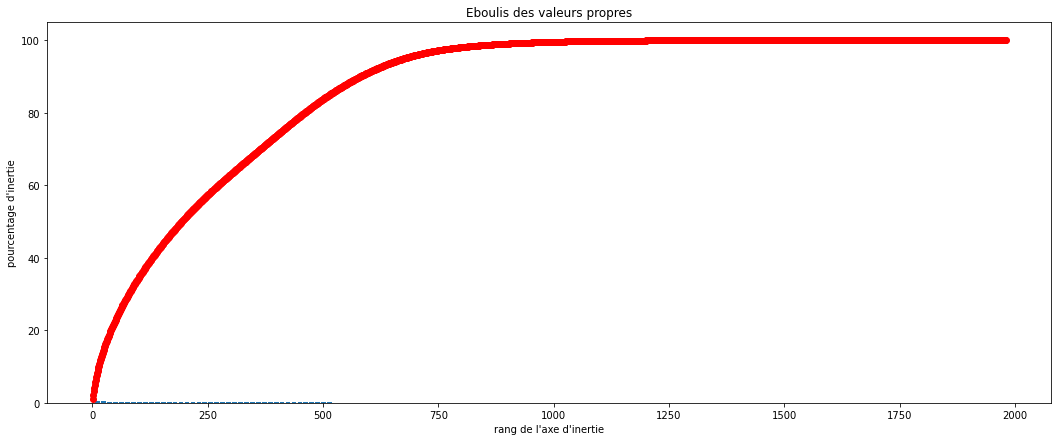

In [7]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=ACP_NB_COMPOSANTES)
pca.fit(X_scaled)
# Eboulis des valeurs propres
display_scree_plot(pca)

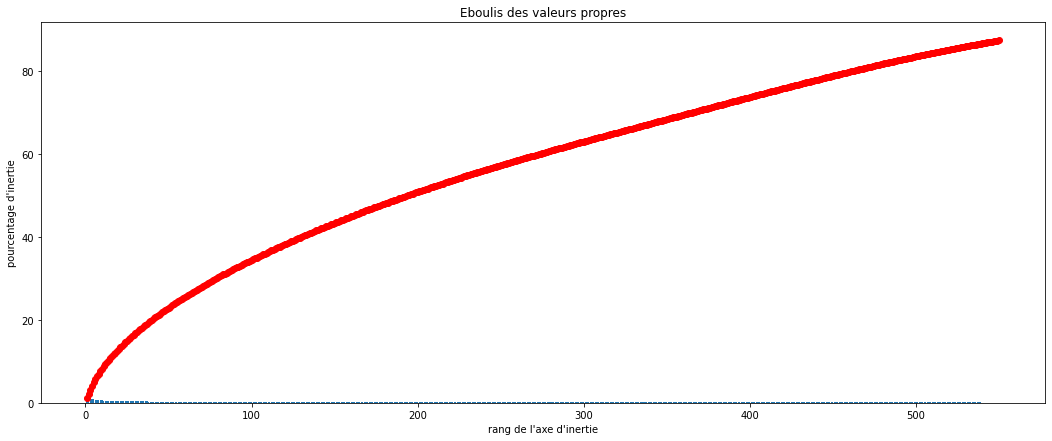

In [8]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=550)
pca.fit(X_scaled)
# Eboulis des valeurs propres
display_scree_plot(pca)

In [ ]:
# choix du nombre de composantes à calculer
ACP_NB_COMPOSANTES = 6
axis_ranks = [(0,1),(2,3),(4,5)]

<div style="display: flex; background-color: Green; padding: 7px;" >

### 3.2. Projection des individus
</div>

In [ ]:
# Projection des individus
X_projected = pca.transform(X_scaled)
pcs = pca.components_

# Theme du ou des parcours auxquels appartient le cours (data, developpement, marketing, etc.)
theme = [df.loc[index, "nutriscore_grade"] for index in df_centre_reduit.index]

for rank in axis_ranks:
    # Projection des individus
    display_factorial_planes(X_projected, ACP_NB_COMPOSANTES, pca, [rank], illustrative_var = theme)
    # Cercle des corrélations
    display_circles(pcs, ACP_NB_COMPOSANTES, pca, [rank], labels = np.array(features))
    display_factorial_planes_by_theme(X_projected, pca, ACP_NB_COMPOSANTES, [rank], illustrative_var = theme, by_theme=True)

<div style="display: flex; background-color: Blue; padding: 15px;" >

## Z. Annexes
</div>


<div style="display: flex; background-color: indigo;" >

#### M.4.3. LGBMClassifier
</div>